In [24]:
# Import needed files and basic setup
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

import data_gen2
import tropical

from ipywidgets import Output
from IPython.display import display, Markdown, Latex, Math, clear_output

%matplotlib notebook
plt.ion()

#%load_ext tikzmagic

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # I don't have a GPU to test this

# Simple translation

\begin{equation*} \max\{ x + 1 - y, 0 \} = \max\{ x + 1, y \} - y \end{equation*}

<IPython.core.display.Javascript object>


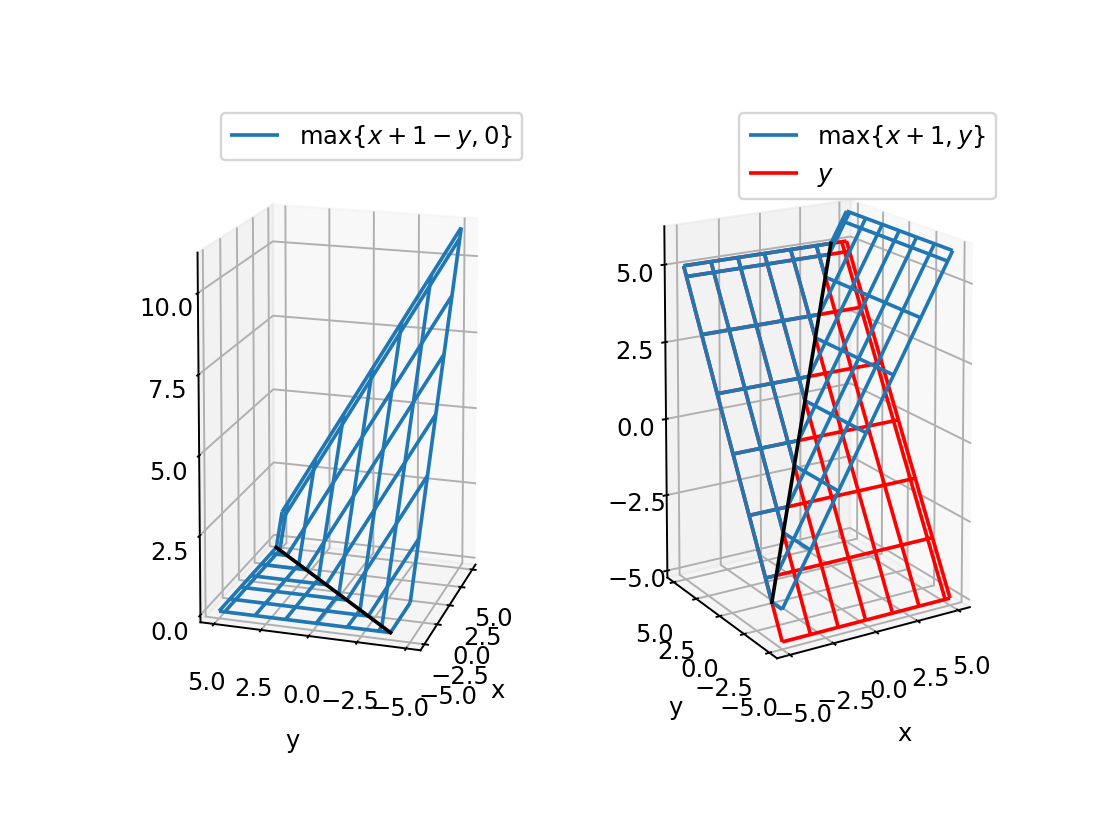

In [29]:
# Code for plotting
fig = plt.figure()
ax = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)

x, y = np.meshgrid(x, y)
X = x.reshape([-1, 1])
Y = y.reshape([-1, 1])

out = np.maximum(x + 1 - y, 0)

ax.plot_wireframe(x, y, out.reshape(x.shape), rstride=16, cstride=16, label='$\max\{x + 1 - y, 0\}$');

ax.plot([-5, 4], [-4, 5], c='k')

ax.set_xlabel('x')
ax.set_ylabel('y')

ax.legend()

out = np.maximum(x+1, y)

ax2.plot_wireframe(x, y, out.reshape(x.shape), rstride=16, cstride=16, label='$\max\{x + 1, y\}$');
ax2.plot_wireframe(x, y, y, rstride=16, cstride=16, color='r', label='$y$');

ax2.plot([-5, 4], [-4, 5], zs=[-4, 5], c='k')

ax2.set_xlabel('x')
ax2.set_ylabel('y')

ax2.legend();

# 2 - 1 - 1 network

We have

$ f(x) = a \max \left\{ \begin{bmatrix} w_1 & w_2 \end{bmatrix} \begin{bmatrix} x_1 \\ x_2 \end{bmatrix} + b_1, 0 \right\} + b_2 $

This has a nonlinear part at

$ w_1 x_1 + w_2 x_2 + b_1 = 0 $

or

$ x_2 = \frac{\displaystyle-w_1 x_1 - b_1}{\displaystyle w_2}. $

If we care about positive negative classification, this crosses the zero hyperplane at

$ 0 = a \max \left\{ \begin{bmatrix} w_1 & w_2 \end{bmatrix} \begin{bmatrix} x_1 \\ x_2 \end{bmatrix} + b_1, 0 \right\} + b_2 $

or

$ - \frac{\displaystyle b_2}{\displaystyle a} = \max \left\{ \begin{bmatrix} w_1 & w_2 \end{bmatrix} \begin{bmatrix} x_1 \\ x_2 \end{bmatrix} + b_1, 0 \right\} $

There are now two options:

When $w_1 x_1 + w_2 x_2 + b_1 > 0$, we have

$ -\frac{\displaystyle b_2}{\displaystyle a} = w_1 x_1 + w_2 x_2 + b_1 $

or

$ x_2 = \frac{\displaystyle -a w_1 x_1 - a b_1 - b_2}{\displaystyle  a w_2}. $

When $w_1 x_1 + w_2 x_2 + b_1 < 0$, we have

$ - \frac{\displaystyle b_2}{\displaystyle a} = 0 $

which only occurs when 

$b_2 = 0$

independent of $x$.

Converting this to tropical form gives

\begin{align*}
f(x) &= (a^+ - a^-) \left( \max \left\{ \begin{bmatrix} w_1^+ & w_2^+ \end{bmatrix} \begin{bmatrix} x_1 \\ x_2 \end{bmatrix} + b_1, \begin{bmatrix} w_1^- & w_2^- \end{bmatrix} \begin{bmatrix} x_1 \\ x_2 \end{bmatrix} \right\} - \begin{bmatrix} w_1^- & w_2^- \end{bmatrix} \begin{bmatrix} x_1 \\ x_2 \end{bmatrix} \right) + b_2 \\
&= \left(a^+ \max \left\{ \begin{bmatrix} w_1^+ & w_2^+ \end{bmatrix} \begin{bmatrix} x_1 \\ x_2 \end{bmatrix} + b_1, \begin{bmatrix} w_1^- & w_2^- \end{bmatrix} \begin{bmatrix} x_1 \\ x_2 \end{bmatrix} \right\} + a^-\begin{bmatrix} w_1^- & w_2^- \end{bmatrix} \begin{bmatrix} x_1 \\ x_2 \end{bmatrix}\right) - \\
&\phantom{=} - \left(a^- \max \left\{ \begin{bmatrix} w_1^+ & w_2^+ \end{bmatrix} \begin{bmatrix} x_1 \\ x_2 \end{bmatrix} + b_1, \begin{bmatrix} w_1^- & w_2^- \end{bmatrix} \begin{bmatrix} x_1 \\ x_2 \end{bmatrix} \right\} + a^+ \begin{bmatrix} w_1^- & w_2^- \end{bmatrix} \begin{bmatrix} x_1 \\ x_2 \end{bmatrix}\right)
\end{align*}

In [15]:
# Set parameters 
a = np.array([1])
a = a.reshape((-1, 1))
bOuter = -1
bInner = np.array([1])
bInner = bInner.reshape((-1, 1))
w = np.array([[1.0], [1.0]])

def network(x):
    return a*np.maximum(np.matmul(w.T, x) + bInner, 0) + bOuter

In [18]:
Fterms, Gterms = tropical.getTropCoeffs(w.T, bInner, a, bOuter)

In [19]:
display(Math('F = ' + tropical.displayTropPoly(Fterms)))

<IPython.core.display.Math object>

In [20]:
display(Math('G = ' + tropical.displayTropPoly(Gterms)))

<IPython.core.display.Math object>

<IPython.core.display.Javascript object>


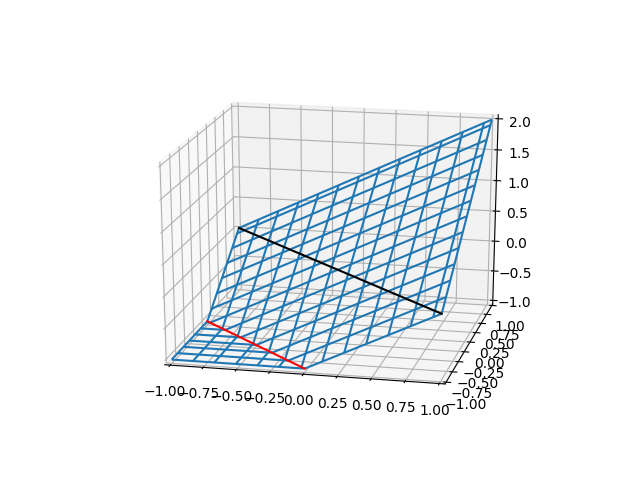

In [21]:
# Plot this structure
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)

x, y = np.meshgrid(x, y)
X = x.reshape([-1, 1])
Y = y.reshape([-1, 1])

into = np.concatenate((X, Y), axis=1)

out = network(into.T)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(x, y, out.reshape(x.shape), rstride=8, cstride=8);

x = np.array([-10, 10])
y = (-w[0]*x - bInner)/w[1]
ax.plot([-1, 0], [0, -1], zs=np.array([bOuter, bOuter]), color='r')

x = np.array([-10, 10])
y = (-a*w[0]*x - a*bInner - bOuter)/(a*w[1])
ax.plot([-1, 1], [1, -1], zs=np.array([0, 0]), color='k')

ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1]);

# XOR problem

<IPython.core.display.Javascript object>


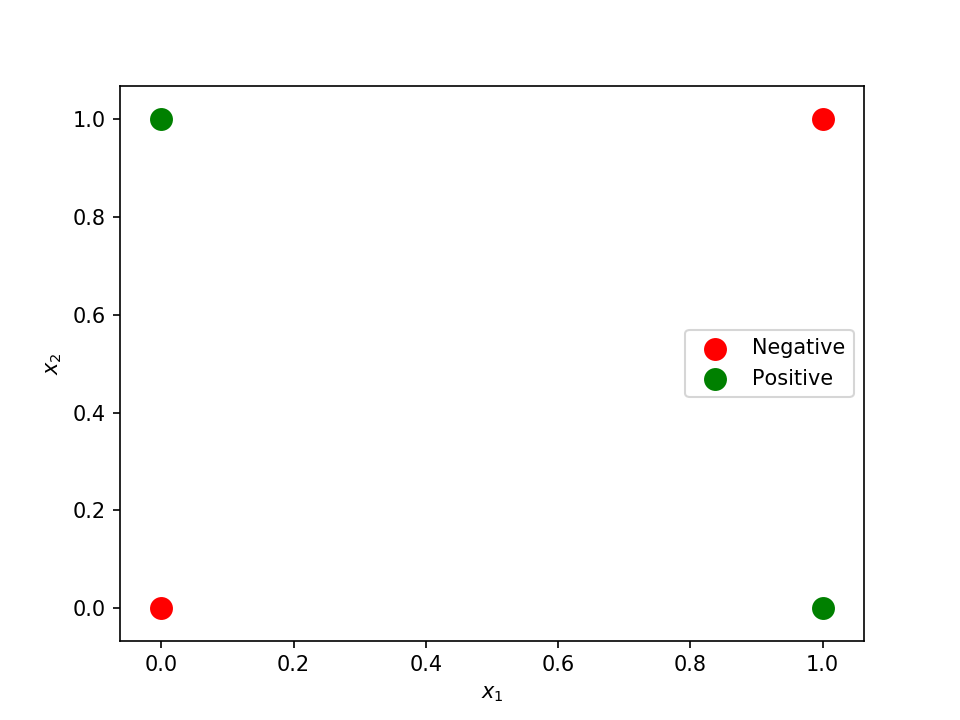

In [35]:
# XOR
fig, ax = plt.subplots()
ax.scatter([0, 1], [0, 1], c='r', alpha=1, s=100, label='Negative');
ax.scatter([1, 0], [0, 1], c='g', alpha=1, s=100, label='Positive');
ax.legend()
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$');

A network that successfully does this classification is

\begin{equation*}
f(x) = \begin{bmatrix} 2 & -4 \end{bmatrix} \max \left\{ \begin{bmatrix} 1 & 1 \\ 1 & 1 \end{bmatrix} \begin{bmatrix} x_1 \\ x_2 \end{bmatrix} + \begin{bmatrix} 0 \\ -1 \end{bmatrix}, 0 \right\} - 1
\end{equation*}

In [26]:
# Setup parameters
a = np.array([[2.0], [-4.0]]).T

bOuter = np.array(-1)

bInner = np.array([[0.0], 
                   [-1.0]])

w = np.array([[1.0, 1.0], 
              [1.0, 1.0]])

def network(x):
    return np.matmul(a, np.maximum(np.matmul(w, x) + bInner, 0)) + bOuter

<IPython.core.display.Javascript object>


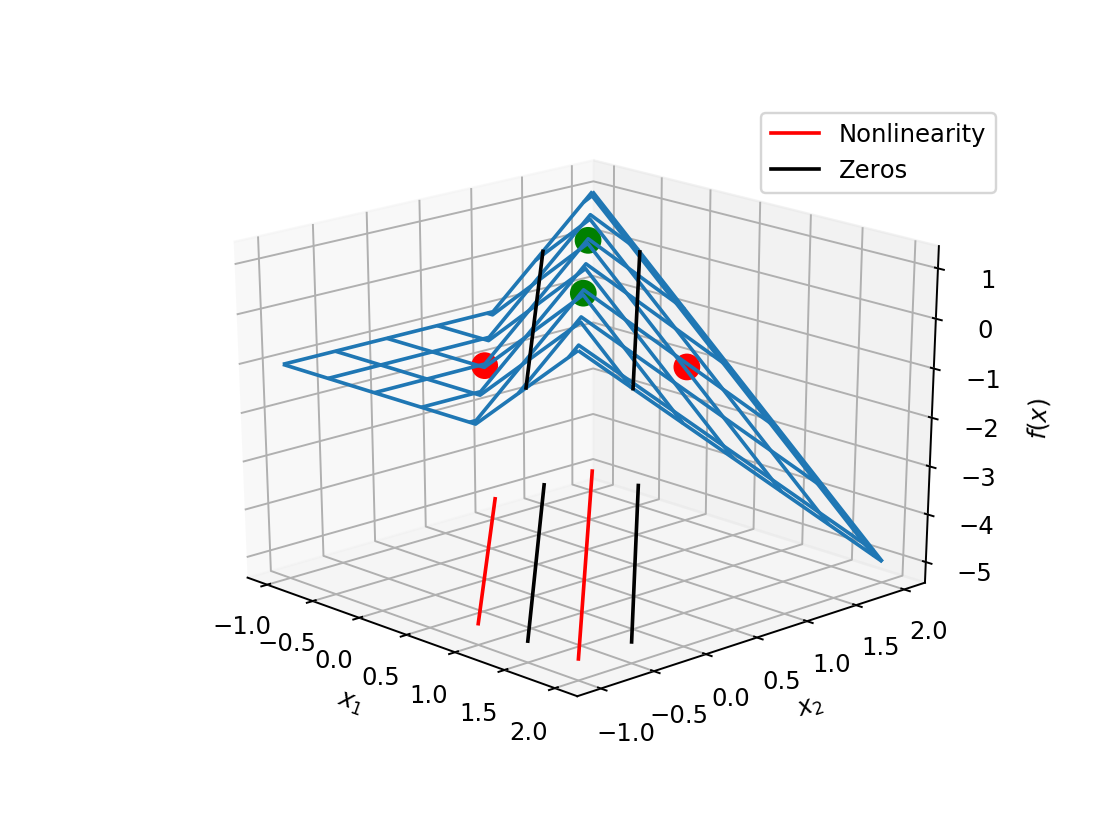

In [27]:
# Plot this
x = np.array([0, 1])
y = np.array([0, 1])

x, y = np.meshgrid(x, y)
X = x.reshape([-1, 1])
Y = y.reshape([-1, 1])

into = np.concatenate((X, Y), axis=1)

out = network(into.T)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = np.array([0, 1])
y = np.array([0, 1])

x, y = np.meshgrid(x, y)
X = x.reshape([-1, 1])
Y = y.reshape([-1, 1])

into = np.concatenate((X, Y), axis=1)

out = network(into.T)




x = np.linspace(-1, 2, 100)
y = np.linspace(-1, 2, 100)

x, y = np.meshgrid(x, y)
X = x.reshape([-1, 1])
Y = y.reshape([-1, 1])

into = np.concatenate((X, Y), axis=1)

out = network(into.T)


ax.plot([2, -1], [-1, 2], zs=[-5, -5], c='r', label='Nonlinearity')

ax.plot([1, -1], [-1, 1], zs=[-5, -5], c='r');


ax.plot_wireframe(x, y, out.reshape(x.shape), rstride=16, cstride=16);

ax.scatter([0, 1], [0, 1], [-1, -1], c='r', alpha=1, s=100);
ax.scatter([1, 0], [0, 1], [1, 1], c='g', alpha=1, s=100);

ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$f(x)$')

# y = (1-2x)/2
# y = (3-2x)/2
ax.plot([-1/2, 2], [2, -1/2], 'k');
ax.plot([-1, 1.5], [3/2, -1], 'k');

ax.plot([-1/2, 2], [2, -1/2], zs=[-5, -5], c='k', label='Zeros');
ax.plot([-1, 1.5], [3/2, -1], zs=[-5, -5], c='k');

ax.legend();



#ax.plot([0, 1], [1, 0], zs=[-1, -1], c='k')
#ax.plot([0, 1], [-1, -2], zs=[-1, -1], c='k')

In [52]:
Fterms, Gterms = tropical.getTropCoeffs(w, bInner, a, bOuter)

In [53]:
display(Math('F = ' + tropical.displayTropPoly(Fterms)))

<IPython.core.display.Math object>

In [54]:
display(Math('G = ' + tropical.displayTropPoly(Gterms)))

<IPython.core.display.Math object>

The network is

$ f(x) = a^T \max\{ w x + b_1, 0 \} + b_2 = \begin{bmatrix} 2 & -4 \end{bmatrix} \max \left\{ \begin{bmatrix} 1 & 1 \\ 1 & 1 \end{bmatrix} \begin{bmatrix} x_1 \\ x_2 \end{bmatrix} + \begin{bmatrix} 0 \\ -1 \end{bmatrix}, 0 \right\} - 1 $

This has nonlinearities at

$ x_1 + x_2 = 0 $

corresponding to the first dimension of the hidden layer and 

$ x_1 + x_2 - 1 = 0 $

corresponding to the second dimension of the hidden layer.

It can be written as

\begin{equation*}
f(x) =
\begin{cases}
a^T w x + a b_1 + b_2, & 1 \leq x_1 + x_2 \\
a^T \begin{bmatrix} w_1^T \\ 0 \end{bmatrix}x + a \begin{bmatrix} b_{11} \\ 0 \end{bmatrix} + b_2, & 0 \leq x_1 + x_2 \leq 1 \\
a^T \begin{bmatrix} 0 \\ w_2^T \end{bmatrix}x + a \begin{bmatrix} 0 \\ b_{12} \end{bmatrix} + b_2, & 1 \leq x_1 + x_2 \leq 0 \\ 
b_2, & x_1 + x_2 \leq 0
\end{cases}
\end{equation*}

This is equivalent to

$ f(x) = F(x) \oslash G(x) = \max\{ -1, -1 + 2x_1 + 2x_2\} - \max\{ 0, -4 + 4x_1 + 4x_2\} $

This has nonlinearities in $F$ at

$ 2x_1 + 2x_2 - 1 = -1 $

or

$ x_1 + x_2 = 0 $

and in $G$ at

$ 4x_1 + 4x_2 - 4 = 0 $

or

$ x_1 + x_2 - 1 = 0. $

Translation to tropical takes the form of, noting

$ W = \begin{bmatrix} w_1 \\ w_2 \end{bmatrix} $

\begin{align*}
f(x) &= a \max\{ W x + b_1, 0 \} + b_2 \\
     &= (a^+ - a^-) \max\{ (W^+ - W^-) x + b_1, 0 \} + b_2 \\
     &= (a^+ \max\{ W^+ x + b_1, W^- x \} + a^- W^- x + b_2) - (a^- \max\{ W^+ x + b_1, W^- x \} + a^+ W^- x) \\
     &= (a^+_1 \max\{w^+_1 x + b_{11}, w^-_1 x \} + a^+_2 \max\{w^+_2 x + b_{12}, w^-_2 x \} + a^- W^- x + b_2) - \\
     &\phantom{=} - (a^-_1 \max\{w^+_1 x + b_{11}, w^-_1 x \} + a^-_2 \max\{w^+_2 x + b_{12}, w^-_2 x \} + a^+ W^- x) \\
     &= ( \max\{a^+_1 w^+_1 x + a^+_1 b_{11}, a^+_1 w^-_1 x \} + \max\{a^+_2 w^+_2 x + a^+_2 b_{12}, a^+_2 w^-_2 x \} + a^- W^- x + b_2) - \\
     &\phantom{=} - (\max\{a^-_1 w^+_1 x + a^-_1 b_{11}, a^-_1 w^-_1 x \} + \max\{a^-_2 w^+_2 x + a^-_2 b_{12}, a^-_2 w^-_2 x \} + a^+ W^- x) \\
     &= (\max\{ a^+_1 w^+_1 x + a^+_1 b_{11} + a^+_2 w^+_2 x + a^+_2 b_{12}, a^+_1 w^+_1 x + a^+_1 b_{11} + a^+_2 w^-_2 x, a^+_1 w^-_1 x + a^+_2 w^+_2 x + a^+_2 b_{12}, a^+_1 w^-_1 x + a^+_2 w^-_2 x \} + a^- W^- x + b_2) - \\
     &\phantom{=} - (\max\{ a^-_1 w^+_1 x + a^-_1 b_{11} + a^-_2 w^+_2 x + a^-_2 b_{12}, a^-_1 w^+_1 x + a^-_1 b_{11} + a^-_2 w^-_2 x, a^-_1 w^-_1 x + a^-_2 w^+_2 x + a^-_2 b_{12}, a^-_1 w^-_1 x + a^-_2 w^-_2 x \} + a^+ W^- x) \\
     &= \left(\max\left\{ a^+ W^+x + a^+ b_1, a^+ \begin{bmatrix} w^+_1 \\ w^-_2 \end{bmatrix}x + a^+ \begin{bmatrix} b_{11} \\ 0 \end{bmatrix}, a^+ \begin{bmatrix} w^-_1 \\ w^+_2 \end{bmatrix}x + a^+ \begin{bmatrix} 0 \\ b_{12} \end{bmatrix}, a^+ W^-x \right\} + a^- W^- x + b_2 \right) - \\
     &\phantom{=} - \left(\max\left\{ a^- W^+x + a^- b_1, a^- \begin{bmatrix} w^+_1 \\ w^-_2 \end{bmatrix}x + a^- \begin{bmatrix} b_{11} \\ 0 \end{bmatrix}, a^- \begin{bmatrix} w^-_1 \\ w^+_2 \end{bmatrix}x + a^- \begin{bmatrix} 0 \\ b_{12} \end{bmatrix}, a^- W^-x \right\} + a^+ W^- x \right)
\end{align*}

\begin{align*}
&= \phantom{=} \max\left\{ a^+ W x + a^+ b_1, a^+ \begin{bmatrix} w_1^T \\ 0 \end{bmatrix}x + a^+ \begin{bmatrix} b_{11} \\ 0 \end{bmatrix}, a^+ \begin{bmatrix} 0 \\ w_2^T \end{bmatrix}x + a^+ \begin{bmatrix} 0 \\ b_{12} \end{bmatrix}, 0 \right\} + b_2 - \\
&\phantom{=} - \max\left\{ a^- W x + a^- b_1, a^- \begin{bmatrix} w_1^T \\ 0 \end{bmatrix}x + a^- \begin{bmatrix} b_{11} \\ 0 \end{bmatrix}, a^- \begin{bmatrix} 0 \\ w_2^T \end{bmatrix}x + a^- \begin{bmatrix} 0 \\ b_{12} \end{bmatrix}, 0 \right\}
\end{align*}

This is similar to what we discussed last semester where we broke the neural net into parts based on the regions where terms were maximal.

\begin{equation*}
f(x) =
\begin{cases}
a W x + a b_1 + b_2, & w_1^T x + b_{11} \geq 0, w_2^T x + b_{12} \geq 0 \\
a \begin{bmatrix} w_1^T \\ 0 \end{bmatrix}x + a \begin{bmatrix} b_{11} \\ 0 \end{bmatrix} + b_2, & w_1^T x + b_{11} \geq 0, w_2^T x + b_{12} \leq 0 \\
a\begin{bmatrix} 0 \\ w_2^T \end{bmatrix}x + a \begin{bmatrix} 0 \\ b_{12} \end{bmatrix} + b_2, & w_1^T x + b_{11} \leq 0, w_2^T x + b_{12} \geq 0 \\ 
b_2, &  w_1^T x + b_{11} \leq 0, w_2^T x + b_{12} \leq 0
\end{cases}
\end{equation*}

We can write this as

\begin{equation*}
f(x) = a\max\left\{ W x + b_1, \begin{bmatrix} w_1^T \\ 0 \end{bmatrix}x + \begin{bmatrix} b_{11} \\ 0 \end{bmatrix}, \begin{bmatrix} 0 \\ w_2^T \end{bmatrix}x + \begin{bmatrix} 0 \\ b_{12} \end{bmatrix}, 0 \right\} + b_2
\end{equation*}

but cannot in general write it as

\begin{equation*}
f(x) = \max\left\{ a W x + a b_1, a \begin{bmatrix} w_1^T \\ 0 \end{bmatrix}x + a \begin{bmatrix} b_{11} \\ 0 \end{bmatrix}, a \begin{bmatrix} 0 \\ w_2^T \end{bmatrix}x + a \begin{bmatrix} 0 \\ b_{12} \end{bmatrix}, 0 \right\} + b_2.
\end{equation*}